# Information Retrieval Exercise 2 Notebook

This is the template notebook for Exercise 2. The specification for the exercise and the corresponding Exercise 2 Quiz submission instance are available on the Moodle page of the course.

## Assumed Knowledge

This Exercise assumes knowedge of Pandas and PyTerrier from Exercise 1. The relevant parts of the PyTerrier documentation are:
 - [Using Terrier indices in PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)
 - [Terrier Retrieval using PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html), e.g. BatchRetrieve
 - [Operators on PyTerrier transformers](https://pyterrier.readthedocs.io/en/latest/operators.html)


## Setup

NB: Windows users may need to use `!pip install  --user python-terrier gensim` -- you can ignore warnings about cython, PATH etc. If in doubt, resort to Colab.

In [ ]:
                                                  !pip install python-terrier gensim

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

import pandas as pd
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 200)

# Datasets for Ex2

For Exercise 2, we'll be using the Datasets API to obtain the files we need for this exercise. PyTerrier actually provides many datasets. You can list all of them using `pt.list_datasets()`.

In [ ]:
pt.list_datasets()

,dataset,topics,topics_lang,qrels,corpus,corpus_lang,index,info_url
0,50pct,"[training, validation]",en,"[training, validation]",None,None,"[ex1, ex2]",None
1,antique,"[train, test]",en,"[train, test]",True,en,None,https://ciir.cs.umass.edu/downloads/Antique/readme.txt
2,vaswani,True,en,True,True,en,True,http://ir.dcs.gla.ac.uk/resources/test_collections/npl/
3,trec-deep-learning-docs,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,None,https://microsoft.github.io/msmarco/
4,trec-deep-learning-passages,"[train, dev, dev.small, eval, eval.small, test-2019, test-2020]",en,"[train, dev, test-2019, test-2020, dev.small]",True,en,None,https://microsoft.github.io/MSMARCO-Passage-Ranking/
...,...,...,...,...,...,...,...,...
289,irds:wikir/en1k/validation,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en1k/validation
290,irds:wikir/en59k,None,None,None,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k
291,irds:wikir/en59k/test,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k/test
292,irds:wikir/en59k/training,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k/training


There are several sets of files we need for Exercise 2:
 - the index for 50% of the TREC GOV corpus. We provide this through the "50pct" dataset, but you will need the username and password that we will assign to you once you sign the user license agreement.
 - the topics (queries) and qrels (relevance assessments) for evaluating the performance of our search engine. These come from the "trec-wt-2004" dataset.

Update your username and password. DO NOT SHARE your login details with other students - all they need to do is to agree to the agreement on Moodle.



In [ ]:
USERNAME = "2576183s"
PASSWORD = "9c8d7804"

dotgov_50pct = pt.get_dataset("50pct", user=USERNAME, password=PASSWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

The size of the "50pct" index is 800MB - this will take a minute or so for Colab to download before we load it for the first time.

In [ ]:
indexref = dotgov_50pct.get_index()
index = pt.IndexFactory.of(indexref)


# Q1

Using this setup, you now have sufficient knowledge from the introductory lab to complete Q1 of this assessed exercise, namely to get the indexing statistics of the "50pct" collection.

In [ ]:
#YOUR SOLUTION
# Print the index collection statistics 
print(index.getCollectionStatistics())

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 0
Number of tokens: 572916194
Field names: []
Positions:   false



# Retrieval & Evaluation

In our experiments, we are using three sets of topics: "hp", "np" and "td". We can obtain them from the `dotgov_topicsqrels` dataset as follows:

In [ ]:
topics = dotgov_topicsqrels.get_topics(variant="hp")
topics.head(5)

,qid,query
0,6,philadelphia streets
1,7,togo embassy
2,9,baltimore
3,17,secure linux
4,29,grand canyon monitoring and research center


Let's create a simple TF_IDF retriever - we will use this for demonstrating IR evaluation using PyTerrier.

In [ ]:
retr = pt.BatchRetrieve(index, wmodel="TF_IDF")

Let's see how we can actually evaluate our TF_IDF retrieval system. Firstly, we'll need the qrels.

In [ ]:
qrels = dotgov_topicsqrels.get_qrels(variant='hp')

We can use `pt.Utils.evaluate(results, qrels)` to evaluate the results    
Args:    
 - metrics, `default = ["map", ndcg"]`, select the evaluation metrics    
 - perquery, `default = False`, select whether to show the mean of the metrics over all queries or the metrics for each query

In [ ]:
res = retr.transform(topics)
eval = pt.Utils.evaluate(res, qrels, metrics=["map"])
eval

{'map': 0.20894845478512017}

However, creating the res dataframe for each system in turn, and then evaluating it is laborious. We strongly recommend using [`pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to evaluate one or more retrieval systems at once, in a declarative manner. 

Take the time to read the [documentation for `pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to understand its available functionality. Q2-Q4 will all require that you adapt the arguments to `pt.Experiment()` and use its output in different ways (e.g. for significance testing).

In [ ]:
pt.Experiment(
    [retr],
     dotgov_topicsqrels.get_topics(variant='hp'),
     dotgov_topicsqrels.get_qrels(variant='hp'), 
     eval_metrics=['map']
)

,name,map
0,BR(TF_IDF),0.208948


# Q2(a)

You now have enough information to complete Q2(a) of the assessed exercise. 

*Hint*: We encourage you to write your own functions that perform reusable operations across different topic sets.

In [ ]:
#YOUR SOLUTION

tfidf_retr = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25_retr = pt.BatchRetrieve(index, wmodel="BM25")
pl2_retr = pt.BatchRetrieve(index, wmodel="PL2")

# required MAP performances of each of the weighting models over the 3 topic sets. TF_IDF used as a baseline
def calculate_MAP_performance(name, topic, qrel):
  print("----------" + name + "----------")
  performance = pt.Experiment(
    [tfidf_retr,bm25_retr,pl2_retr],
     topic,
     qrel, 
     eval_metrics=['map'],
     round={"map" : 4 },
     names = ["TF_IDF", "BM25", "PL2"],
     baseline=0
  )
  print(performance)
  return performance

topics_hp =  dotgov_topicsqrels.get_topics("hp")
qrels_hp = dotgov_topicsqrels.get_qrels("hp")
performance_topics_hp = calculate_MAP_performance("Homepage Finding", topics_hp, qrels_hp)

topics_np =  dotgov_topicsqrels.get_topics("np")
qrels_np = dotgov_topicsqrels.get_qrels("np")
performance_topics_np = calculate_MAP_performance("Named Page Finding", topics_np, qrels_np)

topics_td =  dotgov_topicsqrels.get_topics("td")
qrels_td = dotgov_topicsqrels.get_qrels("td")
performance_topics_td = calculate_MAP_performance("Topic Distillation", topics_td, qrels_td)

import numpy as np
tf_idf = np.array([performance_topics_hp['map'][0], performance_topics_np['map'][0], performance_topics_td['map'][0]])
bm25 = np.array([performance_topics_hp['map'][1], performance_topics_np['map'][1], performance_topics_td['map'][1]])
pl2 = np.array([performance_topics_hp['map'][2], performance_topics_np['map'][2], performance_topics_td['map'][2]])

avg_tf_idf = np.average(tf_idf)
avg_bm25 = np.average(bm25)
avg_pl2 = np.average(pl2)
avg_map = {'TF_IDF' : round(avg_tf_idf,4), 'BM25' : round(avg_bm25,4), 'PL2' : round(avg_pl2,4) }
print("Average Map Performances: ")
print(avg_map)


----------Homepage Finding----------
     name     map  map +  map -  map p-value
0  TF_IDF  0.2089    NaN    NaN          NaN
1    BM25  0.2186   11.0   20.0     0.463462
2     PL2  0.2251   17.0   36.0     0.448418
----------Named Page Finding----------
     name     map  map +  map -  map p-value
0  TF_IDF  0.4477    NaN    NaN          NaN
1    BM25  0.4416    6.0   11.0     0.066561
2     PL2  0.4392   17.0   20.0     0.654736
----------Topic Distillation----------
     name     map  map +  map -  map p-value
0  TF_IDF  0.0698    NaN    NaN          NaN
1    BM25  0.0703   26.0   31.0     0.249291
2     PL2  0.0695   39.0   36.0     0.862098
Average Map Performances: 
{'TF_IDF': 0.2421, 'BM25': 0.2435, 'PL2': 0.2446}


#Q2(b) 

Question 2(b) is concerned with drawing interpolated recall precision graphs, each comparing TFIDF, BM25 and PL2, allowing you to answer the corresponding quiz questions. You will need to use the `"iprec_at_recall"` measure. You should have three curves, respectively addressing the "hp", "np", and "td" topic sets.

*Hint*: Matplotlib has a [`savefig()`](https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/#the-savefig-method) function for saving a PNG of a figure.

Homepage Finding
0    0.213123
1    0.222756
2    0.229183
Name: IPrec@0.2, dtype: float64
0    0.213123
1    0.222756
2    0.229183
Name: IPrec@0.3, dtype: float64
0    0.213123
1    0.222756
2    0.229183
Name: IPrec@0.4, dtype: float64
0    0.213123
1    0.222756
2    0.229183
Name: IPrec@0.5, dtype: float64
----------Homepage Finding----------


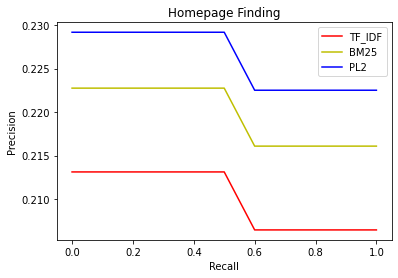

Named Page Finding
0    0.449847
1    0.443682
2    0.443162
Name: IPrec@0.2, dtype: float64
0    0.449847
1    0.443682
2    0.443162
Name: IPrec@0.3, dtype: float64
0    0.449847
1    0.443682
2    0.443162
Name: IPrec@0.4, dtype: float64
0    0.449847
1    0.443682
2    0.443162
Name: IPrec@0.5, dtype: float64
----------Named Page Finding----------


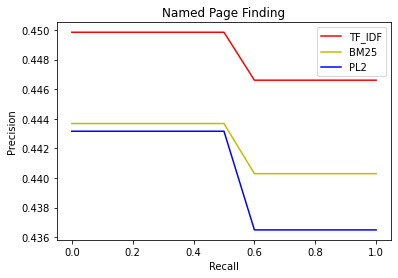

Topic Distillation
0    0.128181
1    0.128443
2    0.124698
Name: IPrec@0.2, dtype: float64
0    0.101728
1    0.103514
2    0.106343
Name: IPrec@0.3, dtype: float64
0    0.086377
1    0.087262
2    0.087748
Name: IPrec@0.4, dtype: float64
0    0.057259
1    0.058282
2    0.058264
Name: IPrec@0.5, dtype: float64
----------Topic Distillation----------


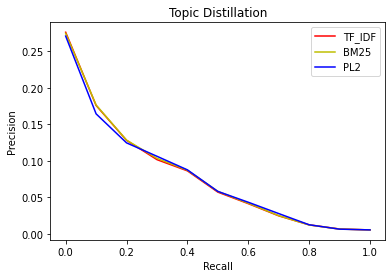

In [ ]:
#YOUR SOLUTION
import matplotlib.pyplot as plt

def plot_graph( title , performance ):
  performance_arr = performance.to_numpy()
  print("----------" + title + "----------")
  plt.plot(np.linspace(0.0,1.0,11),performance_arr[0][1:],'r', label = "TF_IDF")
  plt.plot(np.linspace(0.0,1.0,11),performance_arr[1][1:], 'y',  label = "BM25")
  plt.plot(np.linspace(0.0,1.0,11),performance_arr[2][1:], 'b', label = "PL2")
  plt.legend()
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(title)
  plt.savefig(title + '.png')
  plt.show()

def calculate_iprec_plot(title, topic, qrel):
  performance = pt.Experiment(
    [tfidf_retr,bm25_retr,pl2_retr],
     topic,
     qrel, 
     eval_metrics=['iprec_at_recall'],
     round={'iprec_at_recall' : 4 }
 )
  print(title)
  print(performance['IPrec@0.2'])
  print(performance['IPrec@0.3'])
  print(performance['IPrec@0.4'])
  print(performance['IPrec@0.5'])

  plot_graph(title, performance)

calculate_iprec_plot('Homepage Finding', topics_hp, qrels_hp )
calculate_iprec_plot('Named Page Finding', topics_np, qrels_np )
calculate_iprec_plot('Topic Distillation', topics_td, qrels_td )


#Q2 (c)

Now identify the most effective weighting model in terms of average MAP across the 3 topic sets.

In [ ]:
#YOUR SOLUTION
most_effective_model = max(avg_map, key = avg_map.get)

print("Most Effective Model : ", most_effective_model)

Most Effective Model :  PL2


# Q3 Query Expansion

Query expansion is one of the most well-known and effective techniques for improving the effectiveness of a search engine. We'll be using Terrier's Bo1 query expansion model.

See the [relevant documentation](https://pyterrier.readthedocs.io/en/latest/rewrite.html#bo1queryexpansion) about creating a QE transformer pipeline in PyTerrier using the Bo1 model.

You now have enough information to conduct Q3(a) and (b).



#Q3(a)
Run the required experiments for evaluating the application of query expansion on the best weighting model identified in the previous question.

In [ ]:
#YOUR SOLUTION

bo1 = pt.rewrite.Bo1QueryExpansion(index)
retr_pl2 = pt.BatchRetrieve(index, wmodel="PL2")
pipelineQE = retr_pl2 >> bo1 >> retr_pl2

def cal_QE_map(topic, qrel, title):
  performance = pt.Experiment(
     [pipelineQE],
     topic,
     qrel, 
     eval_metrics=['map'],
     round= {'map' : 4 },
     names = [title]
  )
  print(performance)
  
cal_QE_map(topics_hp, qrels_hp, 'Homepage Finding')
cal_QE_map(topics_np, qrels_np, 'Named Page Finding')
cal_QE_map(topics_td, qrels_td, 'Topic Distillation')



               name     map
0  Homepage Finding  0.2423
                 name     map
0  Named Page Finding  0.4442
                 name     map
0  Topic Distillation  0.0671


#Q3(b)

This question calls for a query-delta bar chart (See example in Lecture 5). You will need to use the ` perquery=True` option for `pt.Experiment()`. 

*Hints*: 
 - You may need a [self-join](https://www.w3schools.com/sql/sql_join_self.asp) on a dataframe.
 - You can iterate through a dataframe using [`dataframe.iterrows()`](https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/)

In [ ]:
#YOUR SOLUTION
def create_query_delta_chart(performanceQE,performancePL2):
  combined_performance = performanceQE.merge( right = performancePL2, left_on='qid', right_on='qid')
  qids = []
  qid_values = []
  inc = 0
  dec = 0
  for i, row in combined_performance.iterrows():
      diff = row['value_x']-row['value_y']
      if (abs(diff) > 0.02):
        if diff > 0:
          inc += 1
        else:
          dec += 1
        qids.append(row['qid'])
        qid_values.append(diff)

  temp1 = {'qid': qids, 'Delta_AP': qid_values}
  temp2 = pd.DataFrame(temp1)
  print("Queries Improved >2% :", inc)
  print("Queries degraded >2%:", dec)

  all_query = topics_td[topics_td['qid'].isin(qids)]
  temp3 = temp2.merge( right = topics_td, left_on='qid', right_on='qid')
  data_to_plot = temp3.sort_values('Delta_AP', ascending= False)
  data_to_plot['xticks'] = data_to_plot['qid']+':' + data_to_plot['query']

  plt.bar( data_to_plot['xticks'], data_to_plot['Delta_AP'])
  plt.ylabel('DELTA AP')
  plt.xlabel('QID: QUERY')
  plt.xticks(rotation = 'vertical')
  plt.title('QUERY DELTA BAR CHART')
  plt.savefig('QueryDeltaBarChartq3.png', bbox_inches ='tight')
  plt.show()
  
  # 3rd displayed
  print(data_to_plot.iloc[2]['xticks'])
  # 10th disoplayed
  print(data_to_plot.iloc[9]['xticks'])
  # most positively affected
  print(data_to_plot.iloc[0]['xticks'])
  # most negatively affected
  print(data_to_plot.iloc[13]['xticks'])


In [ ]:

# With query Expansion metrics, per query
performance_QE_Bo1_PQ = pt.Experiment(
     [pipelineQE],
     topics_td,
     qrels_td, 
     eval_metrics=['map'],
     perquery = True,
     names = ['first']
  )

# PL2 metrics, per query
performancePL2_PQ = pt.Experiment(
     [retr_pl2],
     topics_td,
     qrels_td, 
     eval_metrics=['map'],
     perquery = True,
     names = ['second']
  )

Queries Improved >2% : 8
Queries degraded >2%: 6


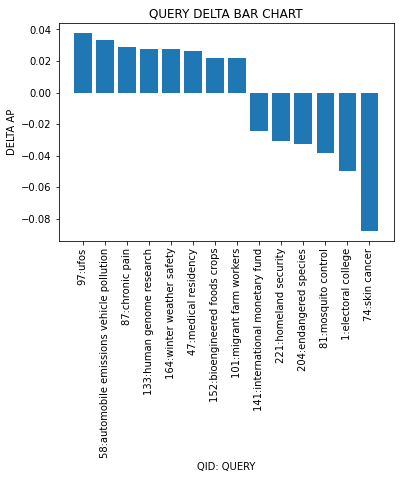

87:chronic pain
221:homeland security
97:ufos
74:skin cancer
ufos -
applypipeline:off ufo^1.782897603 unidentifi^0.293526425 roswel^0.180836979 extraterrestri^0.155083480 forc^0.149192371 fly^0.144446932 blue^0.138189354 book^0.121246517 air^0.115234556 sight^0.114460152
skin cancer -
applypipeline:off skin^1.402936462 cancer^1.233351080 sunscreen^0.081970932 cell^0.071433646 melanoma^0.070226770 sun^0.068207895 squamou^0.067213993 carcinoma^0.063889040 uv^0.055406079 basal^0.054696254


In [ ]:
create_query_delta_chart(performance_QE_Bo1_PQ, performancePL2_PQ)
print('ufos -')
print(pipelineQE.search('ufos')['query'][0])
print('skin cancer -')
print(pipelineQE.search('skin cancer')['query'][0])

In [ ]:
# With query Expansion metrics, average
performance_QE_Bo1 = pt.Experiment(
     [pipelineQE],
     topics_td,
     qrels_td, 
     eval_metrics=['map'],
     round= {'map' : 4 },
     names = ['MAP for Bo1']
  )

# PL2 metrics, average
performancePL2 = pt.Experiment(
     [retr_pl2],
     topics_td,
     qrels_td, 
     eval_metrics=['map'],  
     round= {'map' : 4 }, 
     names = ['MAP for PL2']
  )

print(performance_QE_Bo1)
print(performancePL2)

          name     map
0  MAP for Bo1  0.0671
          name     map
0  MAP for PL2  0.0695


# Q4 Word Embeddings

Q4 asks for a word2vec-based query expansion model. Word2vec (also called word embeddings) is a shallow neural network where semantically similar words end up with similar embedding vectors.

If you haven't taken Text-as-Data, you can do some background reading about word embeddings at:
 - https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
 - https://en.wikipedia.org/wiki/Word2vec
 - https://en.wikipedia.org/wiki/Word_embedding

In general, while word2vec is still a very widely used model, note that it has been surpassed by more complex models such as BERT. But word2vec is still useful to consider in the context of query expansion.


In this part of the exercise, we will use [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), a Python toolkit for working with a word2vec model. 

We are providing a pre-trained word2vec model that Gensim will download and open - the file is very large, so this might take a few minutes to download and a couple of minutes to load. You can read on while it opens.

In [ ]:
import gensim.downloader as api
%time model = api.load("glove-wiki-gigaword-300")

CPU times: user 2min 3s, sys: 1.55 s, total: 2min 4s
Wall time: 2min 4s


`model` is of type [gensim.models.keyedvectors.KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors).

You can think of this as a dictionary mapping string words to the vector embeddings for each word.  For example, we can get the vector for the word `'government'` as follows:

In [ ]:
emb = model.get_vector("government")
print(emb.shape)
print(emb)

(300,)
[ 2.5470e-02 -1.0216e-01 -2.8455e-01  2.8603e-01  1.9018e-01 -4.7529e-01
  1.4468e-01  1.9805e-01 -4.2931e-02 -2.9325e+00 -6.3137e-01  9.7630e-02
  1.0803e-01  5.4072e-01 -1.1834e-02  6.8399e-01  3.7241e-02 -3.8651e-01
  5.1331e-01 -4.0682e-01  3.3802e-01  3.9780e-02  1.0934e+00 -2.6993e-02
 -3.2652e-01  1.8426e-01  2.5084e-02 -1.9201e-02 -1.9761e-01  4.9951e-01
 -2.3426e-01 -1.1926e-01  4.3991e-02  3.2443e-01 -2.6306e-01 -1.7991e-01
  2.3484e-01  3.4124e-01 -3.1304e-01 -1.9777e-01 -1.9651e-01  2.8835e-01
 -1.6815e-01  3.8187e-01 -1.6562e-01 -4.0849e-01 -3.9998e-01  2.6185e-01
 -5.3972e-01  2.4353e-01  1.3366e-01 -3.0213e-01  3.7712e-01  1.8414e-01
  7.4082e-03  1.4511e-01  3.2574e-01  1.6853e-01 -1.0872e-01  1.9417e-02
 -3.2784e-01  3.9864e-01 -7.8588e-01  2.3249e-01  2.8092e-02 -4.3737e-01
  1.3954e-01 -4.0254e-01 -3.2712e-01  4.1180e-01  1.3976e-01  6.8819e-01
  3.9624e-02  2.7002e-02  2.3729e-01 -6.6964e-02  5.5686e-02  2.4415e-01
  1.2575e-03  5.1176e-01  1.3287e-01 -3.3563

As you can see, each word is represented by a 300-dimension vector.

We can also ask `model` for the most similar words to `'government'` using [`model.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). It returns the 10 most similar words, based on the cosine similarity of their emebddings to that of `'government'`. 

See also: [Example in Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#what-can-i-do-with-word-vectors).

In [ ]:
model.most_similar("government")

[('governments', 0.6940836906433105),
 ('administration', 0.6544793844223022),
 ('authorities', 0.6283242702484131),
 ('officials', 0.6262894868850708),
 ('federal', 0.6101000905036926),
 ('opposition', 0.6081914901733398),
 ('official', 0.5788125395774841),
 ('saying', 0.5778090953826904),
 ('public', 0.575609564781189),
 ('ministry', 0.5619341135025024)]

As you can see, some words are clearly related to the original word `'government'`, including some lexical variations (`'governments'`), as well as semantically similar (`"authorities"`) words. You can also see some words that perhaps seem unrelated - probably they are highly weighted because they appeared in similar contexts to `"government"` (e.g. `"saying"`).

#Q4 Word2Vec-based Query Expansion

The next task is to use `model` to develop your custom transformer for a word2vec-based query expansion.

*Hints*:
 - Inspired by Pandas, PyTerrier has the notion of [apply functions](https://pyterrier.readthedocs.io/en/latest/apply.html) for applying transformations.
 - What to do with out-of-vocabulary (OOV) words?
 - How many similar terms to identify for each existing query term?  
 - What is the relative importance of these new terms compared to the existing query terms? e.g. you might want to give more emphasis to the original query terms. 
 - How/if to integrate the Word2Vec cosine distance into your weighting formula? 
 - How to deal with special characters not recognised by the default Terrier query parser, causing a QueryParserException (e.g `/`)?

You now have sufficient information to make a start on Q4.

In [ ]:
#YOUR SOLUTION
def get_similar_words_w2v(query):
  # query = query_row['query']
  terms = query.split(" ")
  new_terms_weight = []
  for each_term in terms:
    new_terms = model.most_similar(each_term)
    new_terms_weight.append(each_term + '^' +str(3))
    for i in range(0,2):
      if (new_terms[i][0].isalnum()):
        new_terms_weight.append(new_terms[i][0] + '^' +str(new_terms[i][1]))
  new_query = ' '.join(map(str, new_terms_weight))
  return new_query

new_queries = topics_td.apply(lambda row: get_similar_words_w2v(row['query']), axis=1)
topics_td_QE = pd.DataFrame({'qid':topics_td['qid'].tolist(), 'query': new_queries.tolist()})

performance_QE_custom = pt.Experiment(
     [retr_pl2],
     topics_td_QE,
     qrels_td, 
     eval_metrics=['map'],  
     round= {'map' : 4 }, 
     names = ['MAP for custom QE']
  )
print(performance_QE_custom)
print(performance_QE_Bo1)
print(performancePL2)


                name     map
0  MAP for custom QE  0.0689
          name     map
0  MAP for Bo1  0.0671
          name     map
0  MAP for PL2  0.0695


In [ ]:
ufo_words = get_similar_words_w2v('ufos')
print(ufo_words)
# nlp_words = get_similar_words_w2v('Natural Language Processing')
# print(nlp_words)

ohio_words = get_similar_words_w2v('ohio dams and locks')
print(ohio_words)

hiv_words = get_similar_words_w2v('hiv aids')
print(hiv_words)

salmon_words = get_similar_words_w2v('salmon')
print(salmon_words)

ufos^3 extraterrestrials^0.6519498825073242 ufo^0.6218308210372925
ohio^3 michigan^0.689485490322113 illinois^0.676207423210144 dams^3 reservoirs^0.7382661700248718 dam^0.7074760794639587 and^3 both^0.7574156522750854 well^0.7293297648429871 locks^3 lock^0.6263008713722229 locking^0.4763319790363312
hiv^3 aids^0.8710564374923706 infection^0.6605448722839355 aids^3 hiv^0.8710564374923706 malaria^0.6543203592300415
salmon^3 trout^0.6639248132705688 fish^0.6541996002197266


Queries Improved : 25
Queries degraded : 50


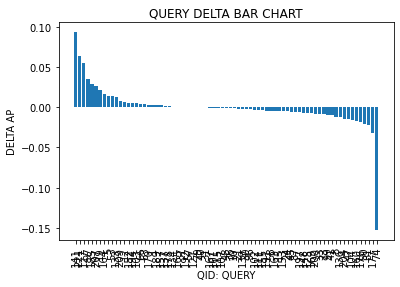

<Figure size 432x288 with 0 Axes>

In [ ]:
performance_QE_custom_PQ = pt.Experiment(
     [retr_pl2],
     topics_td_QE,
     qrels_td, 
     eval_metrics=['map'],
     perquery = True,
     names = ['third']
  )

combined_performance = performance_QE_custom_PQ.merge( right = performancePL2_PQ, left_on='qid', right_on='qid')
qids = []
qid_values = []
inc = 0
dec = 0

for i, row in combined_performance.iterrows():
    diff = row['value_x']-row['value_y']
    if diff > 0:
        inc += 1
    else:
        dec += 1
    qids.append(row['qid'])
    qid_values.append(diff)

temp1 = {'qid': qids, 'Delta_AP': qid_values}
temp2 = pd.DataFrame(temp1)
print("Queries Improved :", inc)
print("Queries degraded :", dec)
all_query = topics_td[topics_td['qid'].isin(qids)]
temp3 = temp2.merge( right = topics_td, left_on='qid', right_on='qid')
data_to_plot = temp3.sort_values('Delta_AP', ascending= False)


plt.bar( data_to_plot['qid'], data_to_plot['Delta_AP'])
plt.ylabel('DELTA AP')
plt.xlabel('QID: QUERY')
plt.xticks(rotation = 'vertical')
plt.title('QUERY DELTA BAR CHART')
plt.show()
plt.savefig('QueryDeltaBarChartq4.png')


# That's all Folks

**Submission Instructions:** Complete this notebook, and answer the related questions in the Exercise 2 Quiz Instance on Moodle. As part of the Quiz, you will be asked to upload your .ipynb notebook solution and answer various corresponding questions as per the exercise specification (use File... Download .ipynb).

Your responses to the Quiz along with your ipynb notebook solution must be submitted by **Wednesday 16th June 2021, 4:30pm**.